In [1]:
import gym
import gym_anytrading
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import pandas as pd

tf.keras.backend.clear_session()


In [2]:
# Define a function to create the model
def getModel():
    visible = keras.Input(shape=(10,2))
    layer = layers.Flatten()(visible)
    layer = layers.Dense(64, activation='relu')(layer)
    layer = layers.Dense(128, activation='relu')(layer)
    layer = layers.Dense(128, activation='relu')(layer)
    layer = layers.Dense(64, activation='relu')(layer)
    layer = layers.Dense(2, activation='linear')(layer)
    model = keras.Model(inputs=visible, outputs=layer)
    return model
m = getModel()
m.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 2)]           0         
_________________________________________________________________
flatten (Flatten)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                1344      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 130   

In [3]:
#Hyper parameters
DISCOUNT_FACTOR = 0.9
EPSILON_MAX = 0.3
EPSILON_MIN = 0.01
EPSILON_T_TO_MIN = 1300 # 1300 time step to minimum epsilon
LEARNING_RATE =0.01
BATCH_SIZE = 128

In [4]:
# DataFrame to log loss values
logging_loss_df = pd.DataFrame(columns =['loss'])


In [5]:
# Define the training function
def train(environment):
    
    model = getModel()
    adam = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(loss='mse', optimizer=adam)

    # List to store state-action-state2-return tuples
    state_action_state2_return = []
    
    observation = environment.reset()
    t = 0
    while True:
        loss = 0
        Q_sa = 0
        current_state = observation
        action_list = np.zeros([2])
        # Calculate epsilon for exploration-exploitation trade-off
        epsilon = EPSILON_MAX - (EPSILON_MAX-EPSILON_MIN) *max(float(t)/EPSILON_T_TO_MIN, 1)
        if random.random() <= epsilon: # explore
            act = env.action_space.sample()
            action_list[act] = 1
        else:
            act = np.argmax(model.predict(current_state.reshape(1, 10, 2))[0])
            action_list[act] = 1

        # Take action and observe the next state and reward
        observation, reward, done, info = environment.step(act)
        if len(state_action_state2_return) >= BATCH_SIZE:
            # Sample a batch of experiences
            batch = random.sample(state_action_state2_return, BATCH_SIZE)
            inputs = np.zeros((len(batch), 10, 2))
            targets = np.zeros((len(batch), 2))

            for i in range(BATCH_SIZE):
                state = batch[i][0]
                action = batch[i][1]
                reward = batch[i][2]
                state2 = batch[i][3]
                terminal = batch[i][4]

                inputs[i:i+1] = state
                # Update the target for the action taken
                targets[i], Q_sa = model.predict(np.array([state, state2]))
                
                if terminal: 
                    Q_sa = 0

                targets[i, action] = reward + DISCOUNT_FACTOR * np.max(Q_sa)                    
        
            inputs_tensor = tf.convert_to_tensor(inputs)
            targets_tensor = tf.convert_to_tensor(targets)
            # Train the model on the batch
            loss = model.train_on_batch(inputs_tensor, targets_tensor)
            logging_loss_df.loc[len(logging_loss_df)] = loss
        
        # Store the experience
        state_action_state2_return.append((current_state, act, reward, observation, done))
        t += 1
        if t % 100 == 0:
            print("timestep {}, loss={}".format(t, loss))
        if done:
            print("info:", info)
            break
            


d:\tech\mtech\sls\project\env\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


timestep 100, loss=0
timestep 200, loss=1.645750735690399e-08
timestep 300, loss=1.3564570799928788e-08
timestep 400, loss=1.416788819597059e-08
timestep 500, loss=1.2879348254557499e-08
timestep 600, loss=2.0382126209028684e-08
timestep 700, loss=6.5680456629024775e-09
timestep 800, loss=5.2702451291963825e-09
timestep 900, loss=6.4163021562535505e-09
timestep 1000, loss=3.008710791618796e-07
timestep 1100, loss=1.0670299366299929e-10
timestep 1200, loss=1.3856703284798044e-10
timestep 1300, loss=1.106261887651172e-10
timestep 1400, loss=1.4629149280853682e-10
timestep 1500, loss=8.680430679808282e-11
timestep 1600, loss=7.055847572878804e-11
timestep 1700, loss=1.3615963911917106e-10
timestep 1800, loss=1.55789381395266e-10
timestep 1900, loss=5.243335626792245e-11
info: {'total_reward': 30.3999999999571, 'total_profit': 0.9414729139602468, 'position': 0}


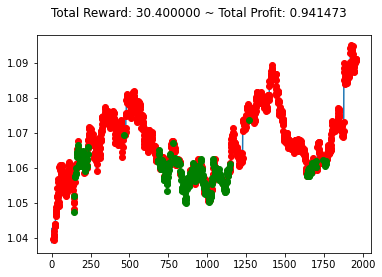

In [6]:

env = gym.make('forex-v0', frame_bound=(50, 2000), window_size=10)
train(env)
plt.cla()
env.render_all()
plt.show()

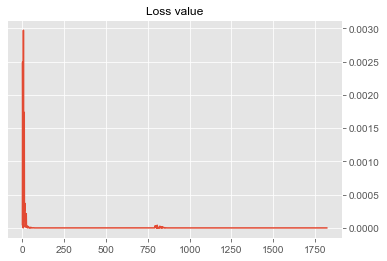

In [7]:
plt.style.use('ggplot')     # if want to use the default style, set 'classic'
plt.rcParams['ytick.right']     = True
plt.rcParams['ytick.labelright']= True
plt.rcParams['ytick.left']      = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['font.family']     = 'Arial'
plt.plot(logging_loss_df['loss'])
plt.title('Loss value', fontsize=12)
plt.show()

info: {'total_reward': -628.1000000000997, 'total_profit': 0.8288597603814589, 'position': 0}


d:\tech\mtech\sls\project\env\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


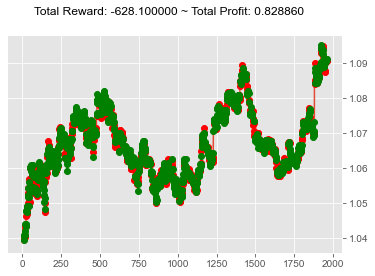

In [8]:
#sample baseline with random actions
env = gym.make('forex-v0', frame_bound=(50, 2000), window_size=10)

observation = env.reset()
while True:
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env.render_all()
plt.show()